# 06. PyTorch Transfer Learning

What is transfer learning?

Transfer learning involves taking the parameters of what one model has learned on another dataset and applying them to our 
own problem

* Pretrained model = foundation models

Now we've got the versions of torch and torchvision, we're after, let's import the code we've written in previous sections so that we don't have to write it all again

In [70]:
import torch
import torchvision

In [71]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## 1. Get Data

We need our pizza, steak and sushi data to build a transfer learning model

In [72]:
import requests
import zipfile
from pathlib import Path

# Setup path to a data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exists, download it nad prepare it...
if image_path.is_dir():
    print(f"{image_path} directory already exists... skipping download")
else:
    print(f"{image_path} does not exist, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak and sushi data
    with open(data_path/ "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("downloading pizza, steak and sushi data")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path/"pizza_steak_sushi.zip", "r") as zip_ref :
        print("Unzipping pizza, steak and sushi data...")
        zip_ref.extractall(image_path)

data/pizza_steak_sushi directory already exists... skipping download


In [73]:
# Setup directory path
train_dir = image_path / "train"
test_dir = image_path / "test"
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## 2. Create Datasets and DataLoaders

Now we've got some data, want to turn it into PyTorch DataLoaders.

To do so we can use `data_setup.py` and the `create_dataloaders()` function we made in 05. PyTorch Going Modular Module

There's one thing we have to think about when loading: how to **transform** it?

And with `torchvision` 0.13+ there's two ways to do this:

1. Manually created transforms. - you define what transforms you want your data to go through.
2. Automatically created transforms - the transforms for your data are defined by the model you'd like to use.

Important point: When using a pretrained model, it's important that the data (including your custom data) that you pass through it is **transformed**  int the same way that the data the model was trained on. 

In [74]:
import torchvision
torch.__version__

'2.3.1'

### 2.1 Creating a tranform for `torchvision.models` (manual creation)

`torchvision.models` contains pretrained models (models ready for transfer learning) righ within `torchvision`

All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]. You can use the following transform to normalize:

In [75]:
from going_modular import data_setup

In [76]:
from torchvision import transforms
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # resize image to 224 * 224
    transforms.ToTensor(),   # get images into range [0, 1]
    normalize   # make sure images have same distribution as ImageNet (where our pretrained models have been trained)
])



In [77]:
from going_modular import data_setup
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=manual_transforms,
                                                                               batch_size=32)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f0d0c0e5790>,
 ['pizza', 'steak', 'sushi'])

### 2.2 Creating a transform for `torchvision.models` (auto creation)

As of `torchvision` v0.13+ there is now support for automatic data transform creation based on the pretrained model weights you are using

In [78]:
# Get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # DEFAULT = Best available weights
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [79]:
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [80]:
# Create DataLoaders using automatic transforms
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transforms,
                                                                               batch_size=32)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f0d64107cb0>,
 ['pizza', 'steak', 'sushi'])

## 3. Getting a pretrained model

There are various places to get a pretrained model, such as:

1. PyTorch domain libraries
2. Libraries like `timm` (torch image models)
3. HuggingFace Hub (for plenty of different models)
4. Papers with code (for models across differnet problem spaces / domain)

### 3.1 Which pretrained model should you use?

* Experiment, experiment, experiment!*

The whole idea of transfer learning: take an already well performing model from a problem space similar to youyr own and then customize to your own problem.

Three things to consider:
1. Speed - how fast does it run?
2. Size - how big is the model?
3. Performance - how well does it go on your chosen problem (e.g. how well does it classify food images?)

Where does the model live ?

Is it on device? (like a self driving car)

or does it live on a server?

Looking at https://pytorch.org/vision/0.19/models.html#table-of-all-available-classification-weights

Which model should we choose?

For our case (deploying food mini on a mobile device), it looks like EffnetB0 is one of our best options in terms of performance vs size.

However, in the light of the Bitter Lesson, if we had infinite compute, we'd likely pick the biggest model + most parameters + most general we could.


### 3.2 Seting up a pretrained model

Want to create an instance of a pretrained EffnetB0 - https://pytorch.org/vision/0.19/models/generated/torchvision.models.efficientnet_b0.html#torchvision.models.efficientnet_b0

In [81]:
# OLD method of creating a pretrained model (prior to torchvision v0.13)
model = torchvision.models.efficientnet_b0(pretrained = True)

/data/workspace/shahjahan/miniconda3/envs/learning/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/data/workspace/shahjahan/miniconda3/envs/learning/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [82]:
# New method of creating a pretrained model (torchvision v0.13+)
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights).to(device)
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [83]:
model.features

Sequential(
  (0): Conv2dNormActivation(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU(inplace=True)
  )
  (1): Sequential(
    (0): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), 

In [84]:
model.avgpool

AdaptiveAvgPool2d(output_size=1)

In [85]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

### 3.3 Getting a summary of our model with `torchinfo.summary()`

In [86]:
# Print a summary with torchinfo 
from torchinfo import summary
summary(model=model,
        input_size=(1, 3, 224, 224), # example of [batch_size, color_channels, height, width]
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

### 3.4 Freezing the base model and changing the output layer to suit our needs

With a feature extractor model, typically you will freeze the base layers of a pretrained/ foundation model and update the output layers to suit your own problem.

In [87]:
# freeze all the base layers in EffNetB0
for param in model.features.parameters():
    #print(param)
    param.requires_grad = False

In [88]:
# Print a summary with torchinfo 
from torchinfo import summary
summary(model=model,
        input_size=(1, 3, 224, 224), # example of [batch_size, color_channels, height, width]
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [89]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [90]:
# update the classifier head of our model to suit our problem
from torch import nn
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model.classifier = nn.Sequential(
    nn.Dropout( p =0.2, inplace= True),
    nn.Linear(in_features= 1280,
              out_features=len(class_names))
).to(device)

model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

In [91]:
# Print a summary with torchinfo 
from torchinfo import summary
summary(model=model,
        input_size=(1, 3, 224, 224), # example of [batch_size, color_channels, height, width]
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

## 4. Train Model

In [92]:
# Define loss and Optimizer 
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)



In [93]:
# import train function
from going_modular import engine

# Set the manual seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the time
from timeit import default_timer as timer

start_time = timer()


# Setup the training and save the results
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=50,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time - start_time:.3f} seconds")

  2%|▏         | 1/50 [00:27<22:14, 27.24s/it]

Epoch: 1 | train_loss: 1.0929 | train_acc: 0.4023 | test_loss: 0.9125 | test_acc: 0.5502


  4%|▍         | 2/50 [00:54<21:34, 26.97s/it]

Epoch: 2 | train_loss: 0.8703 | train_acc: 0.7773 | test_loss: 0.7901 | test_acc: 0.8153


  6%|▌         | 3/50 [01:21<21:18, 27.19s/it]

Epoch: 3 | train_loss: 0.7648 | train_acc: 0.8047 | test_loss: 0.7434 | test_acc: 0.8561


  8%|▊         | 4/50 [01:49<20:58, 27.35s/it]

Epoch: 4 | train_loss: 0.7114 | train_acc: 0.7578 | test_loss: 0.6344 | test_acc: 0.8655


 10%|█         | 5/50 [02:17<20:51, 27.81s/it]

Epoch: 5 | train_loss: 0.6252 | train_acc: 0.7930 | test_loss: 0.6238 | test_acc: 0.8864


 12%|█▏        | 6/50 [02:45<20:17, 27.67s/it]

Epoch: 6 | train_loss: 0.5769 | train_acc: 0.8984 | test_loss: 0.5714 | test_acc: 0.8759


 14%|█▍        | 7/50 [03:13<19:58, 27.87s/it]

Epoch: 7 | train_loss: 0.5259 | train_acc: 0.9141 | test_loss: 0.5456 | test_acc: 0.8759


 16%|█▌        | 8/50 [03:40<19:21, 27.65s/it]

Epoch: 8 | train_loss: 0.5249 | train_acc: 0.8047 | test_loss: 0.5300 | test_acc: 0.8769


 18%|█▊        | 9/50 [04:03<17:51, 26.13s/it]

Epoch: 9 | train_loss: 0.5667 | train_acc: 0.8125 | test_loss: 0.5080 | test_acc: 0.8456


 20%|██        | 10/50 [04:25<16:30, 24.75s/it]

Epoch: 10 | train_loss: 0.4847 | train_acc: 0.8164 | test_loss: 0.4389 | test_acc: 0.9062


 22%|██▏       | 11/50 [04:47<15:36, 24.01s/it]

Epoch: 11 | train_loss: 0.4314 | train_acc: 0.9336 | test_loss: 0.4617 | test_acc: 0.8759


 24%|██▍       | 12/50 [05:09<14:50, 23.44s/it]

Epoch: 12 | train_loss: 0.4593 | train_acc: 0.8242 | test_loss: 0.4922 | test_acc: 0.8352


 26%|██▌       | 13/50 [05:34<14:42, 23.86s/it]

Epoch: 13 | train_loss: 0.4248 | train_acc: 0.9297 | test_loss: 0.4129 | test_acc: 0.8561


 28%|██▊       | 14/50 [05:59<14:30, 24.18s/it]

Epoch: 14 | train_loss: 0.3555 | train_acc: 0.9453 | test_loss: 0.4274 | test_acc: 0.8561


 30%|███       | 15/50 [06:23<14:12, 24.35s/it]

Epoch: 15 | train_loss: 0.3433 | train_acc: 0.9648 | test_loss: 0.4260 | test_acc: 0.8352


 32%|███▏      | 16/50 [06:49<13:56, 24.61s/it]

Epoch: 16 | train_loss: 0.3640 | train_acc: 0.9609 | test_loss: 0.4297 | test_acc: 0.8352


 34%|███▍      | 17/50 [07:14<13:37, 24.79s/it]

Epoch: 17 | train_loss: 0.3187 | train_acc: 0.9609 | test_loss: 0.4393 | test_acc: 0.8352


 36%|███▌      | 18/50 [07:39<13:19, 24.97s/it]

Epoch: 18 | train_loss: 0.3228 | train_acc: 0.9648 | test_loss: 0.4212 | test_acc: 0.8248


 38%|███▊      | 19/50 [08:07<13:23, 25.91s/it]

Epoch: 19 | train_loss: 0.2895 | train_acc: 0.9648 | test_loss: 0.4325 | test_acc: 0.8352


 40%|████      | 20/50 [08:33<12:58, 25.94s/it]

Epoch: 20 | train_loss: 0.4115 | train_acc: 0.8555 | test_loss: 0.4302 | test_acc: 0.8352


 42%|████▏     | 21/50 [09:02<12:53, 26.67s/it]

Epoch: 21 | train_loss: 0.3348 | train_acc: 0.9492 | test_loss: 0.3527 | test_acc: 0.8561


 44%|████▍     | 22/50 [09:29<12:34, 26.94s/it]

Epoch: 22 | train_loss: 0.3451 | train_acc: 0.8438 | test_loss: 0.3632 | test_acc: 0.8456


 46%|████▌     | 23/50 [09:57<12:15, 27.24s/it]

Epoch: 23 | train_loss: 0.4040 | train_acc: 0.8438 | test_loss: 0.3326 | test_acc: 0.8561


 48%|████▊     | 24/50 [10:22<11:30, 26.57s/it]

Epoch: 24 | train_loss: 0.3105 | train_acc: 0.8438 | test_loss: 0.3782 | test_acc: 0.8561


 50%|█████     | 25/50 [10:45<10:36, 25.46s/it]

Epoch: 25 | train_loss: 0.3346 | train_acc: 0.8320 | test_loss: 0.3605 | test_acc: 0.8561


 52%|█████▏    | 26/50 [11:08<09:49, 24.56s/it]

Epoch: 26 | train_loss: 0.3319 | train_acc: 0.8438 | test_loss: 0.3613 | test_acc: 0.8665


 54%|█████▍    | 27/50 [11:30<09:12, 24.02s/it]

Epoch: 27 | train_loss: 0.3324 | train_acc: 0.8594 | test_loss: 0.4233 | test_acc: 0.8144


 56%|█████▌    | 28/50 [11:54<08:47, 23.96s/it]

Epoch: 28 | train_loss: 0.3185 | train_acc: 0.8438 | test_loss: 0.3857 | test_acc: 0.8665


 58%|█████▊    | 29/50 [12:21<08:41, 24.82s/it]

Epoch: 29 | train_loss: 0.2748 | train_acc: 0.9609 | test_loss: 0.3447 | test_acc: 0.8665


 60%|██████    | 30/50 [12:49<08:32, 25.62s/it]

Epoch: 30 | train_loss: 0.2992 | train_acc: 0.9258 | test_loss: 0.3333 | test_acc: 0.8561


 62%|██████▏   | 31/50 [13:15<08:11, 25.88s/it]

Epoch: 31 | train_loss: 0.3682 | train_acc: 0.8281 | test_loss: 0.3222 | test_acc: 0.8561


 64%|██████▍   | 32/50 [13:42<07:52, 26.25s/it]

Epoch: 32 | train_loss: 0.3437 | train_acc: 0.8398 | test_loss: 0.3404 | test_acc: 0.8665


 66%|██████▌   | 33/50 [14:09<07:30, 26.49s/it]

Epoch: 33 | train_loss: 0.2423 | train_acc: 0.9844 | test_loss: 0.3699 | test_acc: 0.8248


 68%|██████▊   | 34/50 [14:37<07:08, 26.77s/it]

Epoch: 34 | train_loss: 0.2269 | train_acc: 0.9688 | test_loss: 0.4099 | test_acc: 0.8456


 70%|███████   | 35/50 [15:05<06:47, 27.16s/it]

Epoch: 35 | train_loss: 0.4089 | train_acc: 0.8477 | test_loss: 0.4068 | test_acc: 0.8049


 72%|███████▏  | 36/50 [15:31<06:18, 27.05s/it]

Epoch: 36 | train_loss: 0.2934 | train_acc: 0.8516 | test_loss: 0.3419 | test_acc: 0.8456


 74%|███████▍  | 37/50 [15:59<05:54, 27.30s/it]

Epoch: 37 | train_loss: 0.2283 | train_acc: 0.9609 | test_loss: 0.3197 | test_acc: 0.8561


 76%|███████▌  | 38/50 [16:27<05:29, 27.45s/it]

Epoch: 38 | train_loss: 0.3497 | train_acc: 0.8281 | test_loss: 0.3409 | test_acc: 0.8456


 78%|███████▊  | 39/50 [16:54<05:01, 27.40s/it]

Epoch: 39 | train_loss: 0.3626 | train_acc: 0.8438 | test_loss: 0.3375 | test_acc: 0.8561


 80%|████████  | 40/50 [17:22<04:35, 27.57s/it]

Epoch: 40 | train_loss: 0.2657 | train_acc: 0.8555 | test_loss: 0.3752 | test_acc: 0.8665


 82%|████████▏ | 41/50 [17:51<04:10, 27.80s/it]

Epoch: 41 | train_loss: 0.3557 | train_acc: 0.8516 | test_loss: 0.4620 | test_acc: 0.7945


 84%|████████▍ | 42/50 [18:18<03:41, 27.63s/it]

Epoch: 42 | train_loss: 0.3426 | train_acc: 0.8594 | test_loss: 0.3498 | test_acc: 0.8665


 86%|████████▌ | 43/50 [18:46<03:13, 27.67s/it]

Epoch: 43 | train_loss: 0.2463 | train_acc: 0.9492 | test_loss: 0.3281 | test_acc: 0.8769


 88%|████████▊ | 44/50 [19:13<02:45, 27.65s/it]

Epoch: 44 | train_loss: 0.3433 | train_acc: 0.8359 | test_loss: 0.3293 | test_acc: 0.8665


 90%|█████████ | 45/50 [19:41<02:18, 27.72s/it]

Epoch: 45 | train_loss: 0.3389 | train_acc: 0.8438 | test_loss: 0.3269 | test_acc: 0.8873


 92%|█████████▏| 46/50 [20:09<01:50, 27.63s/it]

Epoch: 46 | train_loss: 0.2852 | train_acc: 0.8555 | test_loss: 0.3536 | test_acc: 0.8769


 94%|█████████▍| 47/50 [20:36<01:22, 27.64s/it]

Epoch: 47 | train_loss: 0.2918 | train_acc: 0.8555 | test_loss: 0.3299 | test_acc: 0.8769


 96%|█████████▌| 48/50 [21:04<00:55, 27.64s/it]

Epoch: 48 | train_loss: 0.2108 | train_acc: 0.9844 | test_loss: 0.3509 | test_acc: 0.8665


 98%|█████████▊| 49/50 [21:29<00:26, 26.78s/it]

Epoch: 49 | train_loss: 0.2054 | train_acc: 0.9922 | test_loss: 0.3167 | test_acc: 0.8665


100%|██████████| 50/50 [21:56<00:00, 26.33s/it]

Epoch: 50 | train_loss: 0.2472 | train_acc: 0.9727 | test_loss: 0.3508 | test_acc: 0.8561
[INFO] Total training time: 1316.331 seconds


In [94]:
results

{'train_loss': [1.092929594218731,
  0.8702523037791252,
  0.7647847905755043,
  0.7114243283867836,
  0.6252069808542728,
  0.5769402272999287,
  0.5259447954595089,
  0.5249013304710388,
  0.566716842353344,
  0.4847007244825363,
  0.4314369335770607,
  0.45929963886737823,
  0.42484137043356895,
  0.3555467426776886,
  0.34334516897797585,
  0.36397603526711464,
  0.3187436889857054,
  0.3227794002741575,
  0.28949033096432686,
  0.411541236564517,
  0.3347948584705591,
  0.34514122642576694,
  0.40401545353233814,
  0.3105452209711075,
  0.3345882575958967,
  0.331911601126194,
  0.3324347585439682,
  0.318459240719676,
  0.2748330980539322,
  0.2991894204169512,
  0.36819947697222233,
  0.3437264394015074,
  0.2423349106684327,
  0.2268611341714859,
  0.4088667817413807,
  0.2933719689026475,
  0.22826437558978796,
  0.34966446831822395,
  0.3626495013013482,
  0.26572182308882475,
  0.35573398508131504,
  0.34256015438586473,
  0.2462804727256298,
  0.34331652522087097,
  0.33892

## 5. Evaluating our model by plotting the loss curves

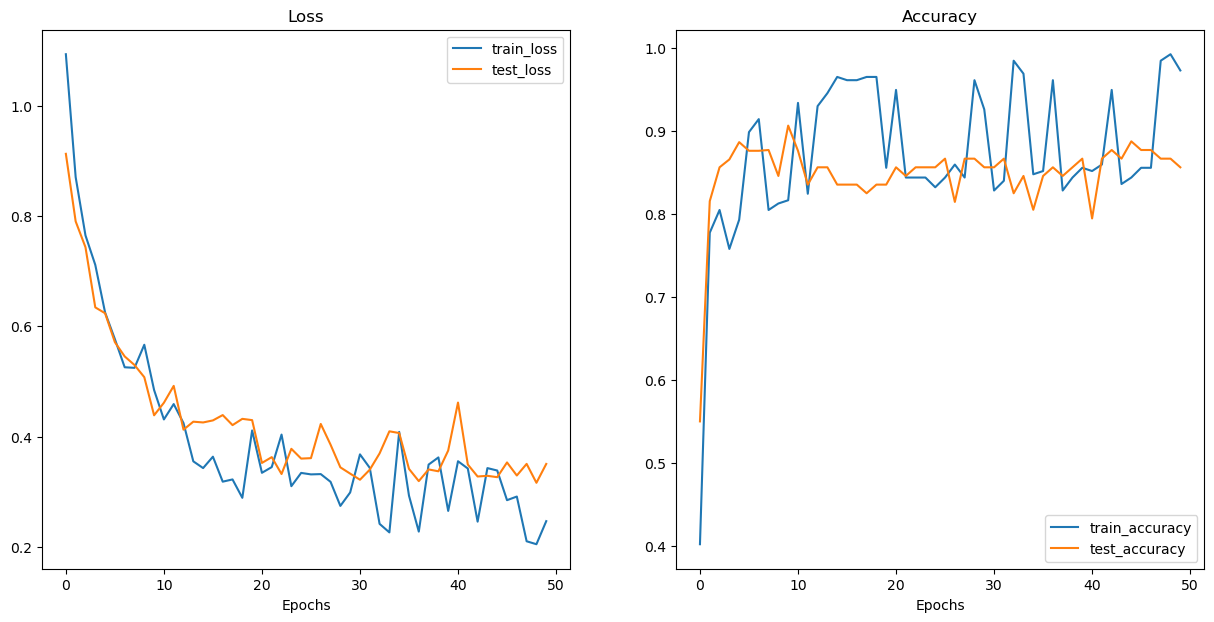

In [95]:
from helper_functions import plot_loss_curves

plot_loss_curves(results)

## 6. Make predictions on images on the test set

Let's adhere to the data explorer's motto of * visualize visualize visualize *!

And make some qualitative predictions on our test set

Some things to keep in mind when making predictions

We have to make sure our test/custom data is:
* Same shape
* Sama datatype
* Same device
* Same transform

To do this automatically, let's create a function called `pred_and_plot_image()`:

1. Take in a trained model, a list of class name, a filepath to target image, an image size, a transform and a target device
2. Open the image with `PIL.Image.Open()`
3. Create a transform if one doesn't exist
4. Make sure the model is on target device
5. Turn the model to `model.eval()` mode to make sure it's ready for inference 
6. Transform the target image and make sure its dimensionality is suited for the model (this mainly relates to batch size)
7. Make a prediction on the image by passing to the model
8. Convert the model's output logits to prediction probabilities using `torch.softmax()`
9. Convert model's prediction probabilities to prediction labels using `torch.argmax()`
10. Plot the image with `matplotlib` and set the title to prediction label from step 9 and prediction probability from step 8

In [96]:
from typing import List, Tuple

from PIL import Image

import matplotlib.pyplot as plt

# 1. Take in a trained model, class names, image path, image size, a transform and target device
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str, 
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):
    
    
    # 2. Open image
    img = Image.open(image_path)

    # 3. Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    ### Predict on image ### 

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
      # 6. Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
      transformed_image = image_transform(img).unsqueeze(dim=0)

      # 7. Make a prediction on image with an extra dimension and send it to the target device
      target_image_pred = model(transformed_image.to(device))

    # 8. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 9. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 10. Plot image with predicted label and probability 
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False)

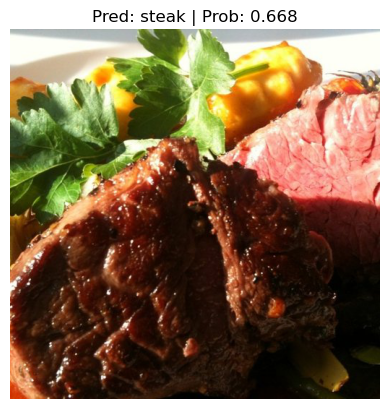

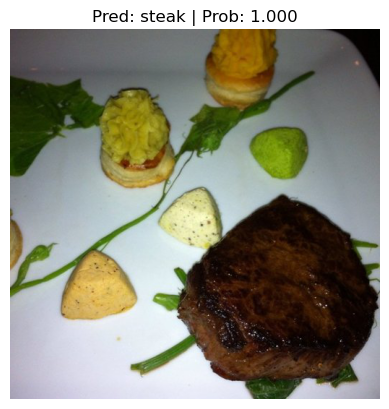

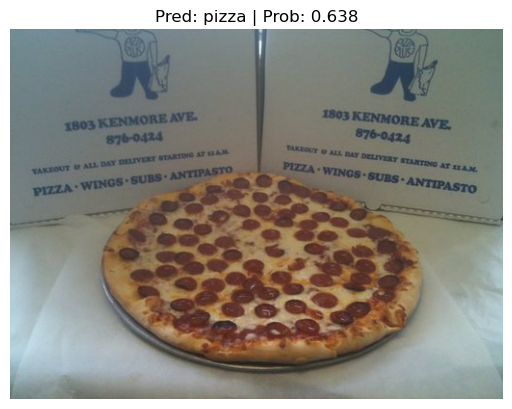

In [97]:
# Get a random list of image paths from test set
import random
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg")) # get list all image paths from test data 
test_image_path_sample = random.sample(population=test_image_path_list, # go through all of the test image paths
                                       k=num_images_to_plot) # randomly select 'k' image paths to pred and plot

# Make predictions on and plot the images
for image_path in test_image_path_sample:
    pred_and_plot_image(model=model, 
                        image_path=image_path,
                        class_names=class_names,
                        # transform=weights.transforms(), # optionally pass in a specified transform from our pretrained model weights
                        image_size=(224, 224))

### 6.1 Make predictions on custom image

data/04-pizza-dad.jpeg already exists, skipping download.


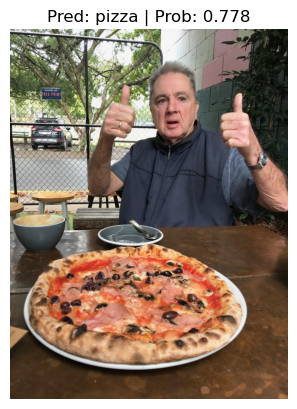

In [98]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)

![alt text](<kinds of transfer learning 1 - Copy.png>)

![alt text](<kinds of transfer learning 2 - Copy.png>)